# **Fashion MNIST Pytorch**

In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [29]:
# Set random seed for reproducibility

torch.manual_seed(42)

In [30]:
# Check for GPU

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 1. Visualizing the Dataset

In [31]:
path_to_dataset = "/kaggle/input/fashionmnist/fashion-mnist_train.csv"


#To visualize the training dataset
df = pd.read_csv(path_to_dataset)
print(df.head())

   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      2       0       0       0       0       0       0       0       0   
1      9       0       0       0       0       0       0       0       0   
2      6       0       0       0       0       0       0       0       5   
3      0       0       0       0       1       2       0       0       0   
4      3       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0        30        43         0   
3       0  ...         3         0         0         0         0         1   
4       0  ...         0         0         0         0         0         0   

   pixel781  pixel782  pixel783  pixel784  
0         0         0         

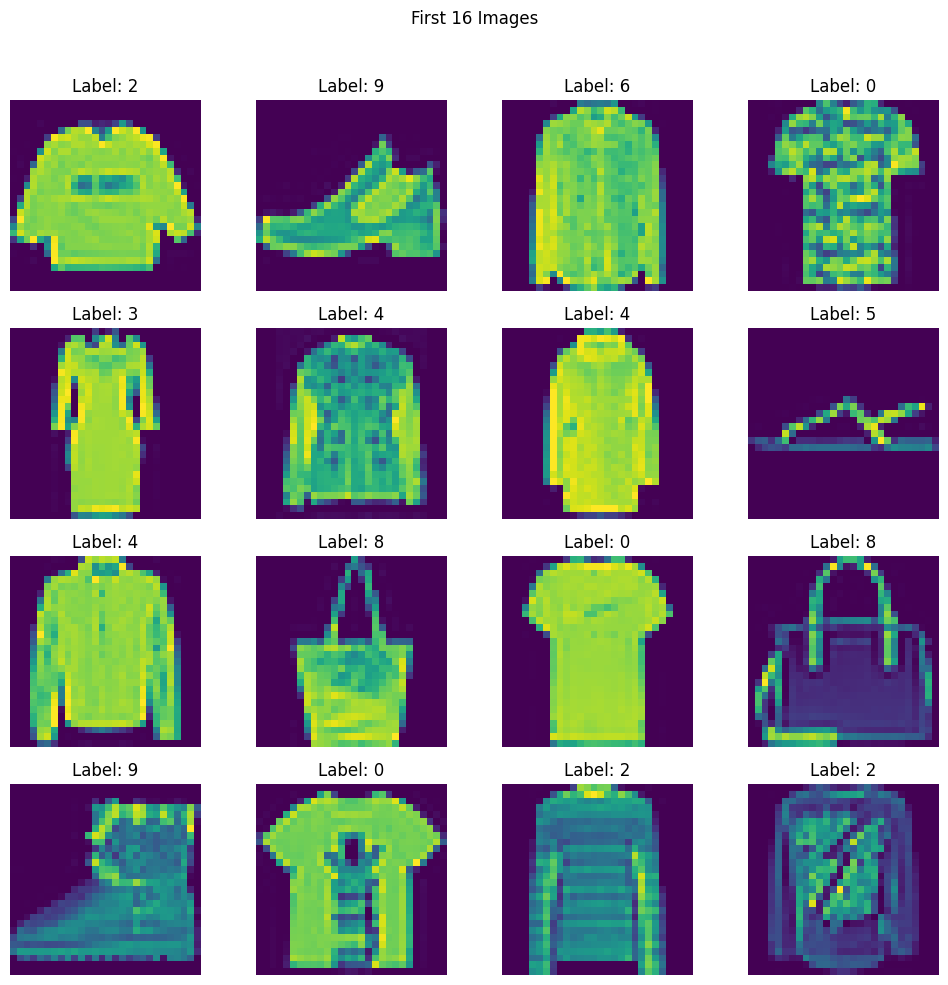

In [32]:
# Create a 4x4 grid of images
fig, axes = plt.subplots(4, 4, figsize=(10,10))
fig.suptitle("First 16 Images", fontsize=12)

for i, ax in enumerate(axes.flat):
    img = df.iloc[i,1:].values.reshape(28,28) # Reshape to 28x28
    ax.imshow(img)                            # Display in grayscale
    ax.axis('off')                            # Remove axis for a cleaner look
    ax.set_title(f"Label: {df.iloc[i,0]}")    # Show the label

plt.tight_layout(rect=[0,0,1,0.96])           # Adjust layout ti fit the title
plt.show()

## 2. Preparing the Dataset

In [33]:
# Train Test split

X = df.iloc[:,1:].values
y = df.iloc[:,0].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Scaling inputs
X_train = X_train / 255.0
X_test = X_test / 255.0


## 3. Creating the Dataloaders

In [34]:
class CustomDataset(Dataset):

    def __init__(self, features, labels):

        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):

        return len(self.features)

    def __getitem__(self,index):

        return self.features[index], self.labels[index]


In [35]:
# create train_dataset and test_dataset object

train_dataset = CustomDataset(X_train,y_train)
test_dataset = CustomDataset(X_test, y_test)

# create train and test loader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)


## 4. Defining the NN Architecture

In [36]:
class MyNN(nn.Module):

    def __init__(self, num_features):

        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features,128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64 ),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(64,10)
        )

    def forward(self, x):

        return self.model(x)

In [37]:
# set learning rate and epochs

epochs = 100
lr = 0.1
total_loss = []

# instantiate the model

model = MyNN(X_train.shape[1])
model = model.to(device)

# loss function

criterion = nn.CrossEntropyLoss()

# optimizer

optimizer = optim.SGD(model.parameters(), lr = lr, weight_decay=1e-4)


## 5. Training the model

In [38]:
for epoch in range(epochs):

    total_epoch_loss = 0
    
    for batch_features, batch_labels in train_loader:

        # move data to gpu
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        
        # forward pass
        output = model(batch_features)

        # calculate loss
        loss = criterion(output, batch_labels)

        # back pass
        optimizer.zero_grad()
        loss.backward()

        # update gradients
        optimizer.step()

        total_epoch_loss = total_epoch_loss + loss.item()
        
    avg_loss = total_epoch_loss/len(train_loader)
    total_loss.append(avg_loss)

    if epoch%10==0:
        print(f"Epoch: {epoch}   |  Loss: {avg_loss}")

Epoch: 0   |  Loss: 0.6249084644317627
Epoch: 10   |  Loss: 0.36783314737677575
Epoch: 20   |  Loss: 0.32084967653950053
Epoch: 30   |  Loss: 0.30498932077238955
Epoch: 40   |  Loss: 0.290096302015086
Epoch: 50   |  Loss: 0.2813802748893698
Epoch: 60   |  Loss: 0.2757849528218309
Epoch: 70   |  Loss: 0.2715306938836972
Epoch: 80   |  Loss: 0.2697894318761925
Epoch: 90   |  Loss: 0.2610011895932257


## 6. Evaluating the model

In [39]:
model.eval()

def calculate_accuracy(loader):
    
    total = 0
    correct = 0 

    with torch.inference_mode():
    
        for batch_features, batch_labels in loader:
    
            # move data to gpu
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
            
            outputs = model(batch_features)
    
            _ , predicted = torch.max(outputs,1)
    
            total = total + batch_labels.shape[0]
    
            correct = correct + (predicted == batch_labels).sum().item()
            
    return correct/total

calculate_accuracy(train_loader)
calculate_accuracy(test_loader)

print(f"The train accuracy comes out to be: {round(calculate_accuracy(train_loader)*100,1)}%")
print(f"The test accuracy comes out to be: {round(calculate_accuracy(test_loader)*100,1)}%")


The train accuracy comes out to be: 93.3%
The test accuracy comes out to be: 88.3%


Text(0.5, 1.0, 'Loss Curve')

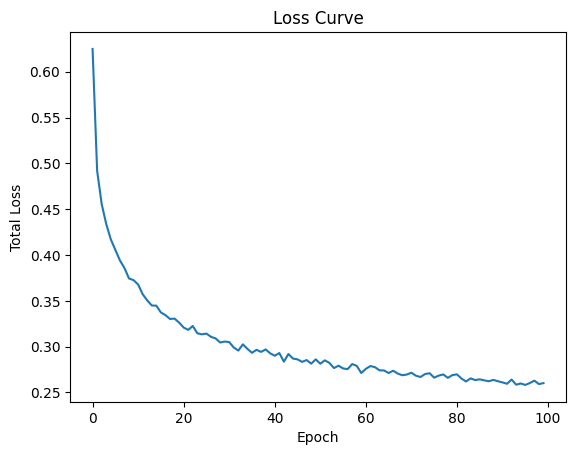

In [40]:
# Plotting the Loss curve

plt.plot(total_loss)
plt.xlabel("Epoch")
plt.ylabel("Total Loss")
plt.title("Loss Curve")